# Heatwave in the Netherlands

As an impact of global warming, an increase in temperature has been reported, which can lead to potential health risks and environmental stress. Several research studies have been presented over the years, such as in this [paper](https://www.mdpi.com/2072-4292/14/3/561), where they explain the change in Land surface temperature over several regions.

Thus, in this notebook, we want to showcase a tool for mapping heatwaves using Sentinel-3 products. For this, we focused on the Netherlands and used specific conditions proposed by the ["National Heatwave Plan"](https://www.rivm.nl/en/heat/national-heatwave-plan) in the Netherlands. The condition implies:

> 5 days >25
and
> 3 days >30

Moreover, in De Bilt, a municipality in the province of Utrecht had a temperature of 25°C at least five days in a row, with at least three days hotter than 30 °C 


https://nltimes.nl/2023/09/08/dutch-heat-record-broken-third-day-row-warm-sunny-weekend-ahead

In [1]:
import openeo
import json
from pathlib import Path
import folium

In [2]:
connection = openeo.connect(
    "openeo.dataspace.copernicus.eu"
).authenticate_oidc()

Authenticated using refresh token.


Let us load 5 month data for the area of interest

In [3]:
def read_json(filename: str) -> dict:
    with open(filename) as input:
        field = json.load(input)
    return field


date = ["2023-06-01", "2023-10-30"]
aoi = read_json("Netherlands_polygon.geojson")

In [4]:
m = folium.Map([52.2, 5], zoom_start=7)
folium.GeoJson(aoi).add_to(m)
m

In [5]:
lst = connection.load_collection(
    "SENTINEL3_SLSTR_L2_LST",
    temporal_extent=date,
    spatial_extent=aoi,
    bands=["LST"],
)

In [6]:
# apply cloud masking

mask = connection.load_collection(
    "SENTINEL3_SLSTR_L2_LST",
    temporal_extent=date,
    spatial_extent=aoi,
    bands=["confidence_in"],
)

mask = mask >= 16384

lst.mask(mask)

Next, we define a User Defined Function (UDF) that takes in the datacube and checks whether both specified conditions are satisfied. Given that the unit of the Land Surface Temperature (LST) layer is Kelvin, the conditions are applied accordingly. If the values meet the designated threshold and continue for more than two days, a new resulting array is generated and returned.

Please note that, here we gave 298.15 and 303.15 Kelvin as two thresholds since we chose a relatively small region. You can change match your requirement. 

In [7]:
udf = openeo.UDF(
    """
import xarray
import numpy as np
from openeo.udf import inspect

def apply_datacube(cube: xarray.DataArray, context: dict) -> xarray.DataArray:
    
    array = cube.values
    inspect(data=[array.shape], message = "Array dimensions")
    res_arr=np.zeros(array.shape)
    for i in range(array.shape[0]-4):
        ar_sub=np.take(array,  range(i, i+5), axis=0)
        res_arr[i]=(np.all(ar_sub>295,axis=0)) & (np.nansum(ar_sub>300,axis=0)>2)
    return xarray.DataArray(res_arr, dims=cube.dims, coords=cube.coords)
"""
)

In [67]:
heatwave_loc = lst.apply_dimension(process=udf, dimension="t")

Now let us use `sum` as the reducer to count the total number of times each pixels had a heat wave in the Netherlands during June-September 2023.

In [68]:
heatwave_loc = heatwave_loc.reduce_dimension(reducer="sum", dimension="t")

Since the workflow covers an entire country, we assume that the processing might take a longer time and the default amount of CPU and memory resources assigned might not be sufficient. Therefore, we can use the job configuration capabilities provided in openEO to execute the workflow when using batch job-based methods.

You can find more information on Job configuration on [this page](https://documentation.dataspace.copernicus.eu/APIs/openEO/job_config.html).

In [10]:
job_options = {
    "executor-memory": "3G",
    "executor-memoryOverhead": "4G",
    "executor-cores": "2",
}

In [11]:
# execute using batch job
heatwave_job = heatwave_loc.execute_batch(
    title="Heatwave Locations in the Netherlands",
    outputfile="Heatwave_NL.nc"
)

0:00:00 Job 'j-240520f051fb4bd7be300b1c0958e2ce': send 'start'
0:00:14 Job 'j-240520f051fb4bd7be300b1c0958e2ce': created (progress 0%)
0:00:20 Job 'j-240520f051fb4bd7be300b1c0958e2ce': created (progress 0%)
0:00:26 Job 'j-240520f051fb4bd7be300b1c0958e2ce': created (progress 0%)
0:00:34 Job 'j-240520f051fb4bd7be300b1c0958e2ce': running (progress N/A)
0:00:44 Job 'j-240520f051fb4bd7be300b1c0958e2ce': running (progress N/A)
0:00:57 Job 'j-240520f051fb4bd7be300b1c0958e2ce': running (progress N/A)
0:01:14 Job 'j-240520f051fb4bd7be300b1c0958e2ce': running (progress N/A)
0:01:33 Job 'j-240520f051fb4bd7be300b1c0958e2ce': running (progress N/A)
0:01:57 Job 'j-240520f051fb4bd7be300b1c0958e2ce': running (progress N/A)
0:02:27 Job 'j-240520f051fb4bd7be300b1c0958e2ce': running (progress N/A)
0:03:05 Job 'j-240520f051fb4bd7be300b1c0958e2ce': running (progress N/A)
0:03:52 Job 'j-240520f051fb4bd7be300b1c0958e2ce': running (progress N/A)
0:04:51 Job 'j-240520f051fb4bd7be300b1c0958e2ce': running (progr

In [13]:
print(f""" The total openEO credits consumed when executing heatwave workflow is 
        {heatwave_job.describe()['costs']} 
        credits."""
     )

 The total openEO credits consumed when executing heatwave workflow is 
        3.0 
        credits.


However, please note that the cost mentioned above was incurred during the preparation of this notebook and could change over time.

## Let's plot the results

In [25]:
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import numpy as np

In [53]:
heatwave = xr.load_dataset("Heatwave_NL.nc")

In [39]:
data = heatwave[["LST"]].to_array(dim="bands")[0]
data.values[data==0] = np.nan
data

<xarray.DataArray (y: 304, x: 431)> Size: 524kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ...,  1.,  1., nan],
       [nan, nan, nan, ...,  1., nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x        (x) float64 3kB 3.375 3.384 3.393 3.402 ... 7.188 7.197 7.206 7.215
  * y        (y) float64 2kB 53.46 53.45 53.44 53.43 ... 50.78 50.77 50.76 50.76
    bands    <U3 12B 'LST'
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform - Geotrellis backend: 0.33.1a1
    description:  
    title:

## Interactive plot

Using Folium, we can easily create an interactive map with a background that allows us to easily spot areas affected by heatwaves.

In [50]:
lon, lat = np.meshgrid(data.x.values.astype(np.float64), data.y.values.astype(np.float64))
cm = matplotlib.colormaps.get_cmap('hot_r')
colored_data = cm(data/10)


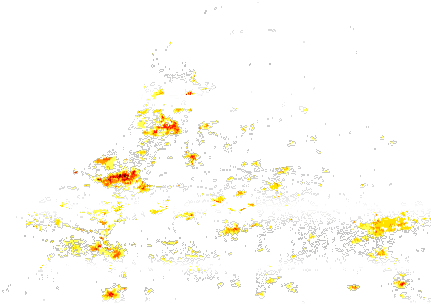

In [51]:
m = folium.Map(location=[lat.mean(), lon.mean()], zoom_start=8)
folium.raster_layers.ImageOverlay(colored_data,
                     [[lat.min(), lon.min()], [lat.max(), lon.max()]],
                     mercator_project=True,
                     opacity=0.5).add_to(m)
m

## Static plot
Using cartopy, we can create a static plot.

Text(0.5, 1.0, '# of Days with Heatwave in 2023')

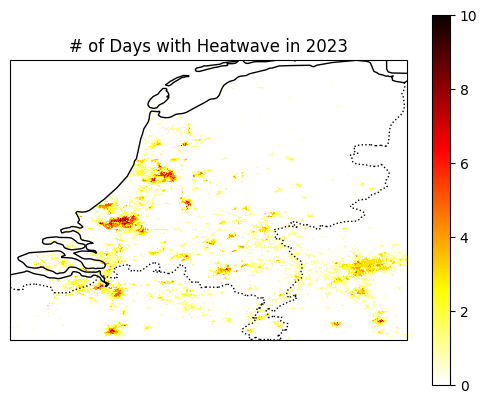

In [62]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

axes = plt.axes(projection=ccrs.PlateCarree())
axes.coastlines()
axes.add_feature(cfeature.BORDERS, linestyle=':')
data.plot.imshow(vmin=0, vmax=10, ax=axes, cmap="hot_r")
axes.set_title("# of Days with Heatwave in 2023")


The above plot shows the number of days with a heatwave in the area of interest in the specified time interval.